In [112]:
import pandas as pd

In [113]:
# 读取降雨径流数据
df = pd.read_csv("/Users/datou/PycharmProjects/model/HengyangSta/HY_data/衡阳站降雨径流.csv", parse_dates=["Date"])
df_copy = df
df.reset_index(drop=True)
df = df.set_index('Date')
df

,Q,P
Date,,
1985-01-01,385,1.218001
1985-01-02,353,1.418061
1985-01-03,350,1.519668
1985-01-04,375,1.140323
1985-01-05,360,2.144906
...,...,...
2001-12-27,766,0.000000
2001-12-28,653,0.000000
2001-12-29,536,0.000000


In [114]:
n_past=15

In [115]:
# 划分数据
test_split = round(len(df) * 0.30)
df_for_training = df[:-test_split]
df_for_testing = df[-(test_split+n_past):]
df_for_testing

,Q,P
Date,,
1996-11-10,393,0.631212
1996-11-11,384,2.396213
1996-11-12,456,3.359430
1996-11-13,471,1.110440
1996-11-14,395,0.492048
...,...,...
2001-12-27,766,0.000000
2001-12-28,653,0.000000
2001-12-29,536,0.000000


In [116]:
# 数据归一化
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)

In [117]:
# 创建数据集 n_past: 时间步长
import numpy as np


def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)

In [118]:
# 这里使用30，意味着将使用过去的30个值(包括目标列在内的所有特性)来预测第31个目标值。
n_past=15
trainX, trainY = createXY(df_for_training_scaled, 15)
testX, testY = createXY(df_for_testing_scaled, 15)
trainX.shape

(4331, 15, 2)

In [119]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
from keras.layers.core import Dense, Dropout, Activation


def build_model():
    """
    1、定义网络
    """
    grid_model = Sequential()  # 层次模型
    grid_model.add(layers.SimpleRNN(units=100, return_sequences=True))
    grid_model.add(Activation('relu'))
    grid_model.add(Dropout(0.1))
    grid_model.add(layers.SimpleRNN(units=100))
    grid_model.add(Dropout(0.1))
    grid_model.add(Dense(1))
    learning_rate = 3e-3
    """
    编译网络：编译需要指定许多参数，这些参数是专为培训网络而定制的。
    具体来说，用于训练网络和用于评估优化算法最小化的网络的优化算法。
    model.compile(optimizer,loss)
    """
    grid_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return grid_model

In [120]:
# 交叉搜索，寻求模型最佳参数，并输出最佳模型
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'batch_size': [16, 20],
              'epochs': [16, 20]}
"""
verbose参数设置为 2，可以将显示的信息量减小到每轮训练的损失。
可以通过将verbose设置为 1 来关闭所有输出
"""
grid_model = KerasRegressor(build_fn=build_model, verbose=1)
grid_search = GridSearchCV(estimator=grid_model,
                           param_grid=parameters,
                           cv=5)

/var/folders/p_/spnxgg1953n3fzj8z81sv51r0000gn/T/ipykernel_42413/779986985.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model, verbose=1)


In [121]:
"""
训练网络
"""
grid_search = grid_search.fit(trainX, trainY)
# 将最佳模型保存在my_model变量中
my_model = grid_search.best_estimator_
# 使用测试数据集测试模型
"""
进行预测
"""
prediction = my_model.predict(testX)
prediction.shape

Epoch 1/16
217/217 [==============================] - 1s 3ms/step - loss: 0.0100
Epoch 2/16
217/217 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 3/16
217/217 [==============================] - 1s 3ms/step - loss: 8.4561e-04
Epoch 4/16
217/217 [==============================] - 1s 3ms/step - loss: 7.3029e-04
Epoch 5/16
217/217 [==============================] - 1s 3ms/step - loss: 7.2584e-04
Epoch 6/16
217/217 [==============================] - 1s 3ms/step - loss: 6.0288e-04
Epoch 7/16
217/217 [==============================] - 1s 3ms/step - loss: 5.4374e-04
Epoch 8/16
217/217 [==============================] - 1s 3ms/step - loss: 6.3810e-04
Epoch 9/16
217/217 [==============================] - 1s 3ms/step - loss: 5.8110e-04
Epoch 10/16
217/217 [==============================] - 1s 3ms/step - loss: 6.0985e-04
Epoch 11/16
217/217 [==============================] - 1s 3ms/step - loss: 5.1525e-04
Epoch 12/16
217/217 [==============================] - 1s 3ms/step - lo

(1863,)

In [122]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 16}

In [123]:
"""
进行预测：训练集
"""
train_predict=my_model.predict(trainX)

217/217 [==============================] - 0s 849us/step


In [124]:
# 逆缩放过程
# 改变形状来进行逆缩放，逆变换后的第一列是我们需要的，所以我们在最后使用了 → [:,0]。
prediction_copies_array = np.repeat(prediction, 2, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction), 2)))[:, 0]
pred

array([330.67706, 335.34006, 334.467  , ..., 570.2116 , 459.56644,
       418.25632], dtype=float32)

In [125]:
# 同样步骤进行逆变换
original_copies_array = np.repeat(testY, 2, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 2)))[:, 0]
original

array([391., 383., 292., ..., 536., 483., 522.])

In [126]:
# 对测试集输出数据进行逆变换
prediction_copies_array = np.repeat(train_predict, 2, axis=-1)
train_pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(train_predict), 2)))[:, 0]
train_pred.shape

(4331,)

In [127]:
# 对测试数据Y进行逆变换
train_original_copies_array = np.repeat(trainY, 2, axis=-1)
train_original = scaler.inverse_transform(np.reshape(train_original_copies_array, (len(trainY), 2)))[:, 0]
train_original.shape

(4331,)

In [128]:
pred = pd.DataFrame(pred)
pred.columns = ['Qsim']
pred

,Qsim
0,330.677063
1,335.340057
2,334.467010
3,258.402100
4,293.069061
...,...
1858,617.838135
1859,648.159485
1860,570.211609
1861,459.566437


In [129]:
train_pred=pd.DataFrame(train_pred)
train_pred.columns=['Qsim']
train_pred

,Qsim
0,465.211578
1,410.137970
2,493.823029
3,518.534729
4,443.383820
...,...
4326,338.051361
4327,323.300232
4328,269.095062
4329,252.368088


In [130]:
original = pd.DataFrame(original)
original.columns = ['Qobs']
original

,Qobs
0,391.0
1,383.0
2,292.0
3,316.0
4,309.0
...,...
1858,766.0
1859,653.0
1860,536.0
1861,483.0


In [131]:
train_original=pd.DataFrame(train_original)
train_original.columns=['Qobs']
train_original

,Qobs
0,479.0
1,542.0
2,557.0
3,476.0
4,464.0
...,...
4326,374.0
4327,315.0
4328,300.0
4329,336.0


In [132]:
df_copy

,Date,Q,P
0,1985-01-01,385,1.218001
1,1985-01-02,353,1.418061
2,1985-01-03,350,1.519668
3,1985-01-04,375,1.140323
4,1985-01-05,360,2.144906
...,...,...,...
6204,2001-12-27,766,0.000000
6205,2001-12-28,653,0.000000
6206,2001-12-29,536,0.000000
6207,2001-12-30,483,0.000000


In [133]:
test_df=df_copy[-test_split:]
test_df

,Date,Q,P
4346,1996-11-25,391,0.067122
4347,1996-11-26,383,0.429786
4348,1996-11-27,292,0.194327
4349,1996-11-28,316,1.199373
4350,1996-11-29,309,0.971816
...,...,...,...
6204,2001-12-27,766,0.000000
6205,2001-12-28,653,0.000000
6206,2001-12-29,536,0.000000
6207,2001-12-30,483,0.000000


In [134]:
train_df=df_copy[n_past:-test_split]
train_df

,Date,Q,P
15,1985-01-16,479,2.189848
16,1985-01-17,542,2.253480
17,1985-01-18,557,0.019066
18,1985-01-19,476,0.030029
19,1985-01-20,464,0.040337
...,...,...,...
4341,1996-11-20,374,0.001667
4342,1996-11-21,315,0.035148
4343,1996-11-22,300,0.069435
4344,1996-11-23,336,0.108885


In [135]:
test_df = test_df.reset_index(drop=True)
test_df = test_df['Date']
test_df

0      1996-11-25
1      1996-11-26
2      1996-11-27
3      1996-11-28
4      1996-11-29
          ...    
1858   2001-12-27
1859   2001-12-28
1860   2001-12-29
1861   2001-12-30
1862   2001-12-31
Name: Date, Length: 1863, dtype: datetime64[ns]

In [136]:
train_df=train_df.reset_index(drop=True)
train_df=train_df['Date']
train_df

0      1985-01-16
1      1985-01-17
2      1985-01-18
3      1985-01-19
4      1985-01-20
          ...    
4326   1996-11-20
4327   1996-11-21
4328   1996-11-22
4329   1996-11-23
4330   1996-11-24
Name: Date, Length: 4331, dtype: datetime64[ns]

In [137]:
test_df_full=pd.concat([test_df,original,pred],axis=1)
test_df_full=test_df_full.reset_index(drop=True)
test_df_full=test_df_full.set_index('Date')
test_df_full.to_csv('/Users/datou/PycharmProjects/model/HengyangSta/HY_data/HY_TestRNN.csv')
test_df_full

,Qobs,Qsim
Date,,
1996-11-25,391.0,330.677063
1996-11-26,383.0,335.340057
1996-11-27,292.0,334.467010
1996-11-28,316.0,258.402100
1996-11-29,309.0,293.069061
...,...,...
2001-12-27,766.0,617.838135
2001-12-28,653.0,648.159485
2001-12-29,536.0,570.211609


In [138]:
train_df_full=pd.concat([train_df,train_original,train_pred],axis=1)
train_df_full=train_df_full.reset_index(drop=True)
train_df_full=train_df_full.set_index('Date')
train_df_full.to_csv('/Users/datou/PycharmProjects/model/HengyangSta/HY_data/HY_TrainRNN.csv')
train_df_full

,Qobs,Qsim
Date,,
1985-01-16,479.0,465.211578
1985-01-17,542.0,410.137970
1985-01-18,557.0,493.823029
1985-01-19,476.0,518.534729
1985-01-20,464.0,443.383820
...,...,...
1996-11-20,374.0,338.051361
1996-11-21,315.0,323.300232
1996-11-22,300.0,269.095062


MAE:210.42457467538338
RMSE:373.00402027373116
NSE:0.9360594522275999
RE:5.760216471197271
Qmaxe:0.13938423570736433
Qmine:0.22437567849761075


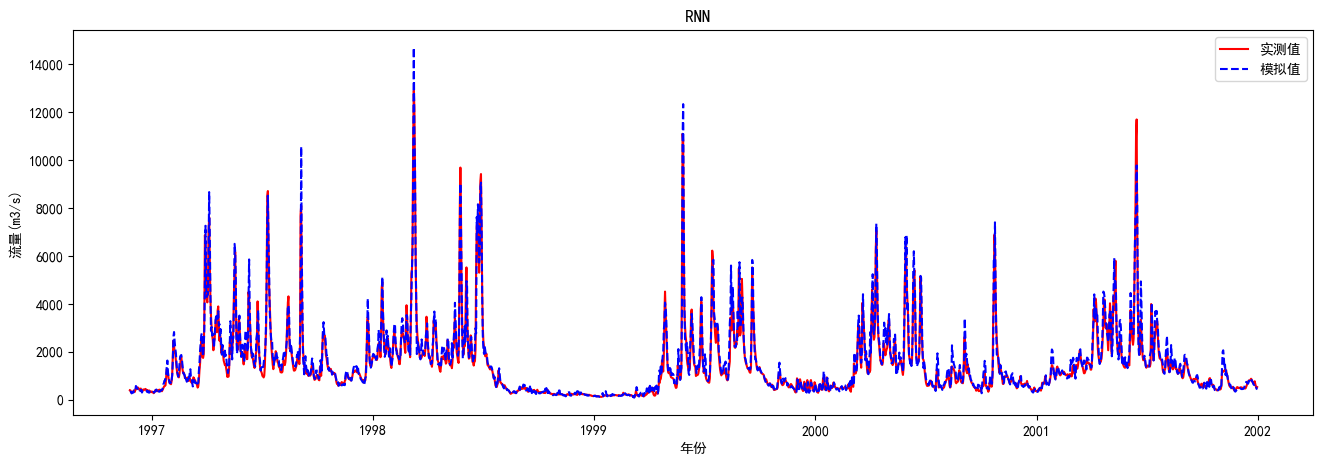

In [139]:
# 计算nash效率系数
# 计算nash效率系数
from matplotlib import pyplot as plt
# 计算nash效率系数
from tool import Indicator

Indicator.eval(test_df_full['Qsim'], test_df_full['Qobs'])
# 比较预测值和原始值，进行绘图展示
plt.figure(figsize=(16,5))
plt.plot(test_df_full['Qobs'], color='red', label='实测值')
plt.plot(test_df_full['Qsim'], color='blue', label='模拟值',linestyle="--")
plt.title(' RNN' )
plt.xlabel('年份')
plt.ylabel('流量(m3/s)')
plt.legend()
plt.savefig("/Users/datou/PycharmProjects/model/HengyangSta/HY_picture/TestRNN.png")
plt.show()

MAE:179.5178059992133
RMSE:323.26392212548666
NSE:0.9424963668840425
RE:5.928148425841132
Qmaxe:0.009267292580409356
Qmine:0.2397427029079861


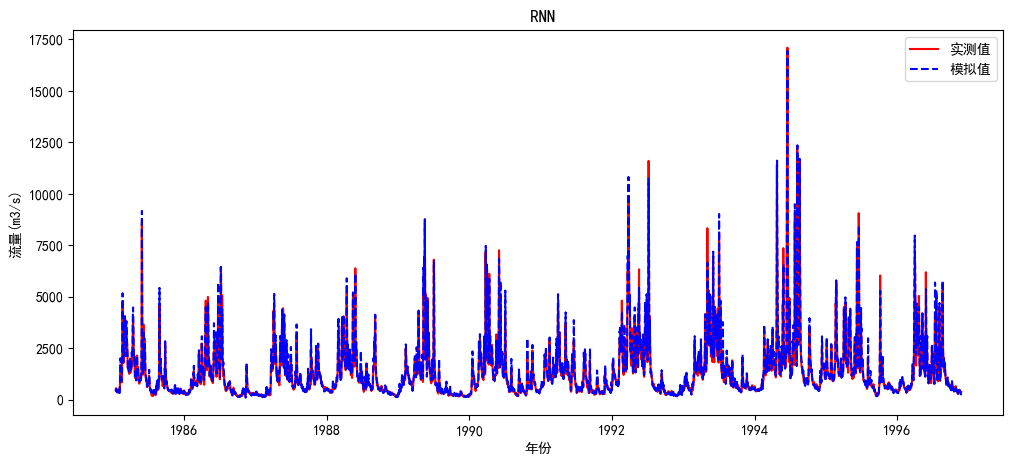

In [140]:
# 计算nash效率系数
Indicator.eval(train_df_full['Qsim'], train_df_full['Qobs'])
# 比较预测值和原始值，进行绘图展示
plt.figure(figsize=(12,5))
plt.plot(train_df_full['Qobs'], color='red', label='实测值')
plt.plot(train_df_full['Qsim'], color='blue', label='模拟值',linestyle="--")
plt.title(' RNN' )
plt.xlabel('年份')
plt.ylabel('流量(m3/s)')
plt.legend()
plt.savefig("/Users/datou/PycharmProjects/model/HengyangSta/HY_picture/TrainRNN.png")
plt.show()

In [141]:
# 预测一些未来值
# 从主 df 数据集中获取我们在开始时加载的最后 30 个值
# df_past = df.iloc[-30:, :]
# # df_30_days_past.tail()
# df_future = pd.read_csv("test.csv", parse_dates=["Date"], index_col=[0])
# Qobs_future = df_future["Q"]
# # 剔除目标列
# df_future["Q"] = 0
# df_future = df_future[["Q", "P"]]
# df_past = df_past.values
# df_future

In [142]:
# 对数据进行缩放
# old_scaled_array = scaler.transform(df_past)
# new_scaled_array = scaler.transform(df_future)
# new_scaled_df = pd.DataFrame(new_scaled_array)
# new_scaled_df.iloc[:, 0] = np.nan
# full_df = pd.concat([pd.DataFrame(old_scaled_array), new_scaled_df]).reset_index().drop(["index"], axis=1)
# full_df

In [143]:
# # 使用特征值进行预测
# full_df_scaled_array = full_df.values
# all_data = []
# time_step = 30
# for i in range(time_step, len(full_df_scaled_array)):
#     data_x = []
#     data_x.append(
#         full_df_scaled_array[i - time_step:i, 0:full_df_scaled_array.shape[1]])
#     data_x = np.array(data_x)
#     prediction = my_model.predict(data_x)
#     all_data.append(prediction)
#     full_df.iloc[i, 0] = prediction

In [144]:
# 对预测进行逆变换
# new_array = np.array(all_data)
# new_array = new_array.reshape(-1, 1)
# prediction_copies_array = np.repeat(new_array, 2, axis=-1)
# y_pred_future = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(new_array), 2)))[:, 0]
# y_pred_future = pd.DataFrame(y_pred_future)
# y_pred_future

In [145]:
# Qobs_future = pd.DataFrame(Qobs_future)
# Qobs_future.reset_index(inplace=True)
# Qobs_future

In [146]:
# df_future_full = pd.concat([Qobs_future, y_pred_future], axis=1)
# df_future_full.columns = ['Date', "Qobs", "Qsim"]
# df_future_full.reset_index(drop=True)
# df_future_full = df_future_full.set_index('Date')
# df_future_full

In [147]:
# 绘图进行数据展示
# nash_futrue = evaluator.nash(df_future_full['Qsim'], df_future_full['Qobs'])
# plt.plot(df_future_full['Qsim'], color='green', label='Qsim')
# plt.plot(df_future_full['Qobs'], color='yellow', label='Qobs')
# plt.title('Verify Prediction-' + 'NSE: ' + format(nash_futrue, '.3f'))
# plt.xlabel('Time')
# plt.ylabel('Runoff(m3/s)')
# plt.legend()
# plt.show()